### <font color='navy'>Objet du projet: construire une I.A, détecteur de faux billets, via entrainement sur une base données préétablie.<font>

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.collections import LineCollection
import itertools as ittls

In [2]:
df_faux_billets = pd.read_csv('./data/billets.csv')

In [3]:
df_faux_billets.head()

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [4]:
df_faux_billets.shape

(170, 7)

In [5]:
#df_faux_billets['is_genuine'] = df_faux_billets['is_genuine'].astype(int)

### Création d'une DataFrame dont les données sont standardisées (hors booleans ofc)

In [6]:
df_faux_billets_CR = df_faux_billets.copy()
columns = df_faux_billets_CR.drop('is_genuine', axis=1).columns

for column in columns:
        df_faux_billets_CR['{}'.format(column)] = (df_faux_billets_CR['{}'.format(column)]-df_faux_billets_CR['{}'.format(column)].mean())/df_faux_billets_CR['{}'.format(column)].std()

# <font color='blue'>ANALYSE UNIVARIEE<font>     

#### Drawing tickets to detect inconsistent forms
It takes time: 170 draws. Change next cell into 'code' then execute it.

import turtle as t
wn = t.Screen()
alex = t.Turtle()
for longueur,largeur_d,largeur_g in zip(round(df_faux_billets['length'],2),round(df_faux_billets['height_right'],2),round(df_faux_billets['height_left'],2)):
    alex.forward(int(longueur))
    alex.right(90)
    alex.forward(int(largeur_d))
    alex.right(90)
    alex.forward(int(longueur))
    alex.right(90)
    alex.forward(int(largeur_g))
    alex.home()

#### <font color='red'>Visualy, drawn tickets seem to be the same.<font>
### <font color='red'>By the way, diagonals are shorter than length....a whole concept but we will do with.<font>

In [7]:
df_faux_billets.describe()

,length,height_left,height_right,margin_low,margin_up,diagonal
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [8]:
df_data = pd.DataFrame()
columns = df_faux_billets.columns
d={}
for column in columns:
    mean = '{:.2f}'.format(df_faux_billets['{}'.format(column)].mean())
    median = '{:.2f}'.format(df_faux_billets['{}'.format(column)].median())
    var = '{:.2f}'.format(df_faux_billets['{}'.format(column)].var())
    mode = '{:.2f}'.format(df_faux_billets['{}'.format(column)].mode()[0])
    ecartype = '{:.2f}'.format(df_faux_billets['{}'.format(column)].std())
    maximum = '{:.2f}'.format(df_faux_billets['{}'.format(column)].max())
    minimum = '{:.2f}'.format(df_faux_billets['{}'.format(column)].min())
    skewn = '{:.2f}'.format(df_faux_billets['{}'.format(column)].skew())
    kurto = '{:.2f}'.format(df_faux_billets['{}'.format(column)].kurtosis())
    d['{}'.format(column)] = mean,median,var,mode,ecartype,maximum,minimum,skewn,kurto
df_data = pd.DataFrame(data=d, index=['moyenne','médianne','variance','modale','écart-type','maximum','minimum','skewness','kurtosis'])

In [9]:
df_data

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
moyenne,0.59,171.94,104.07,103.93,4.61,3.17,112.57
médianne,1.00,171.94,104.06,103.95,4.45,3.17,112.84
variance,0.24,0.09,0.09,0.11,0.49,0.06,0.85
modale,1.00,172.10,104.17,103.76,3.97,3.07,113.38
écart-type,0.49,0.31,0.30,0.33,0.70,0.24,0.92
maximum,1.00,173.01,104.86,104.95,6.28,3.68,113.98
minimum,0.00,171.04,103.23,103.14,3.54,2.27,109.97
skewness,-0.36,0.20,0.03,0.17,0.58,-0.20,-0.66
kurtosis,-1.89,0.59,-0.46,-0.00,-0.74,0.55,-0.53


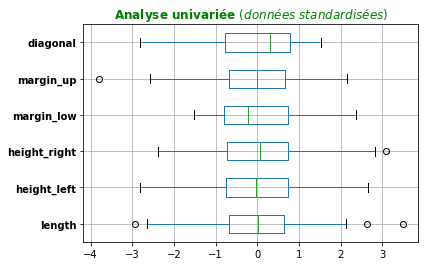

In [10]:
#Boxplot (standardized data)
df_faux_billets_CR.iloc[:,1:7].boxplot(vert=False)
plt.title('Analyse univariée $(données\ standardisées)$', fontsize=12, fontweight='bold', color='green')
plt.yticks(fontsize=10, fontweight='bold')
plt.show()
plt.savefig('./graphiques/boxplot.png', dpi=120)

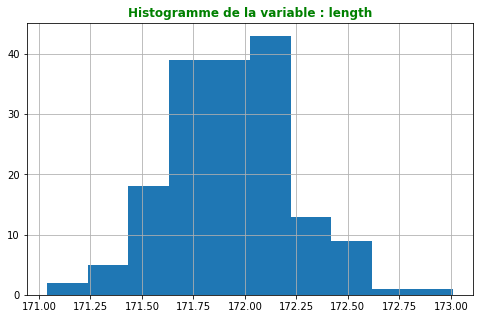

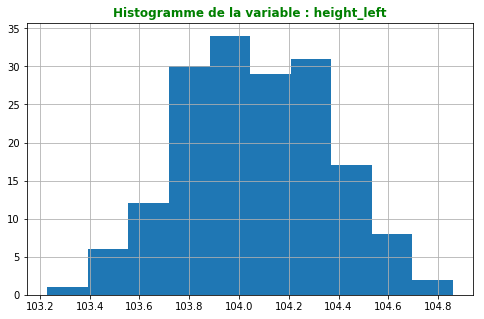

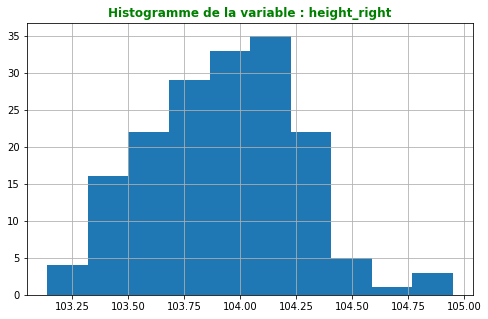

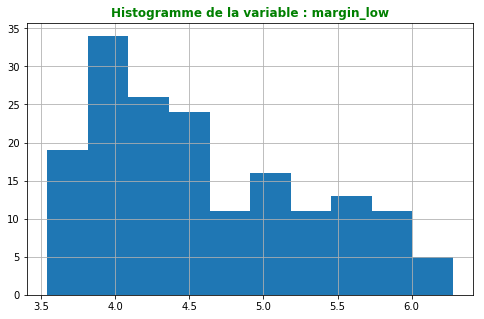

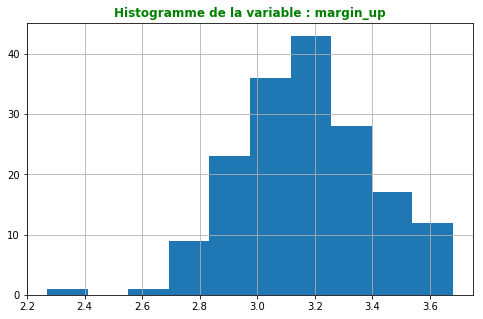

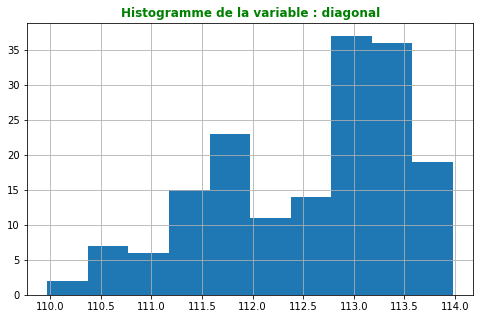

In [11]:
#Histograms
for col in columns[1:7]:
    df_faux_billets.hist(column=col, by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, figsize=(8,5), layout=None, bins=10)
    plt.title('Histogramme de la variable : {}'.format(col), fontsize=12, fontweight='bold', color='green')
    plt.savefig('./graphiques/histogramme_{}.png'.format(col), dpi=120)

In [12]:
#Normal test
for col in columns:
    normal = st.normaltest(df_faux_billets['{}'.format(col)])
    print('''Résultat du test de normalité pour la variable: {} :\n{}\n\n'''.format(col,normal))

Résultat du test de normalité pour la variable: is_genuine :
NormaltestResult(statistic=3.7358690632622986, pvalue=0.15444232834803381)


Résultat du test de normalité pour la variable: length :
NormaltestResult(statistic=3.3194640136970825, pvalue=0.19018994287454516)


Résultat du test de normalité pour la variable: height_left :
NormaltestResult(statistic=2.2228705656519239, pvalue=0.32908629004766338)


Résultat du test de normalité pour la variable: height_right :
NormaltestResult(statistic=0.86921331166220606, pvalue=0.64751931493940529)


Résultat du test de normalité pour la variable: margin_low :
NormaltestResult(statistic=18.382914863433356, pvalue=0.00010190623504607456)


Résultat du test de normalité pour la variable: margin_up :
NormaltestResult(statistic=3.2153229347953074, pvalue=0.20035560476993669)


Résultat du test de normalité pour la variable: diagonal :
NormaltestResult(statistic=14.423966949102116, pvalue=0.0007376925090803203)




# <font color='blue'>ANALYSE BIVARIEE<font>     

### Without explained/target variable

In [13]:
#correlation
df_faux_billets.iloc[:,1:7].corr()

,length,height_left,height_right,margin_low,margin_up,diagonal
length,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
diagonal,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


Corrélations:
Légèrement positive entre 'height_left' et 'heght_right'.
Légèrement négative entre 'margin_low' et 'diagonal' : -0.64

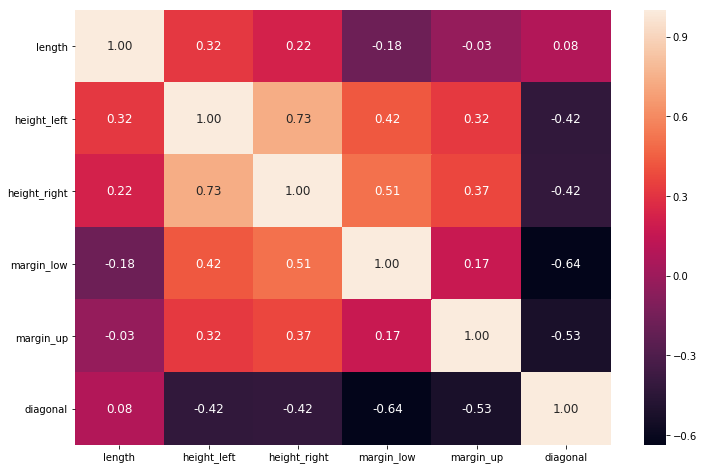

In [14]:
#to heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_faux_billets.iloc[:,1:7].corr(), annot=True, fmt=".2f",annot_kws={'size':12})
plt.yticks(rotation=0)
plt.savefig('./graphiques/heatmap_variables_hors_cible.png', dpi=120)
plt.show()

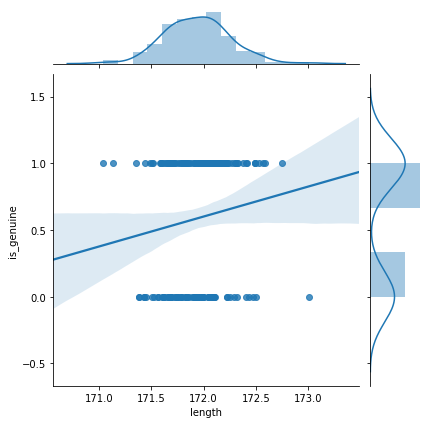

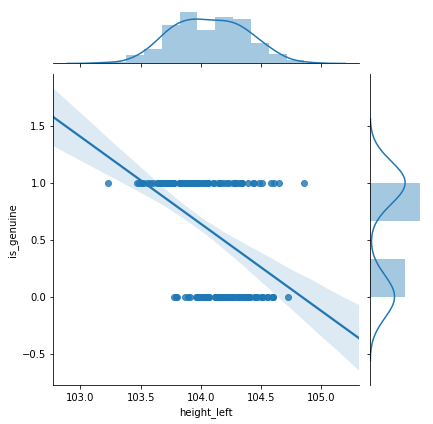

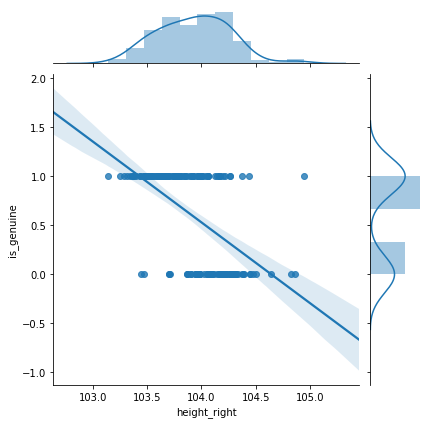

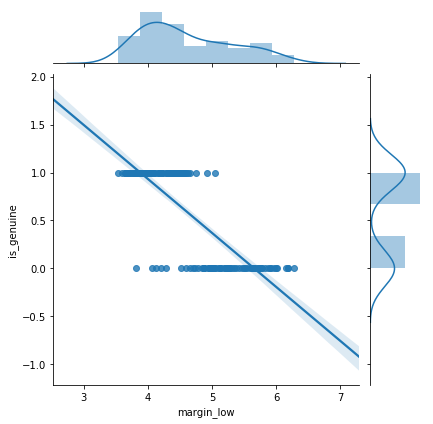

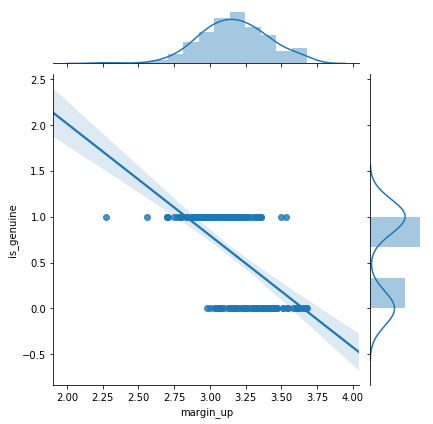

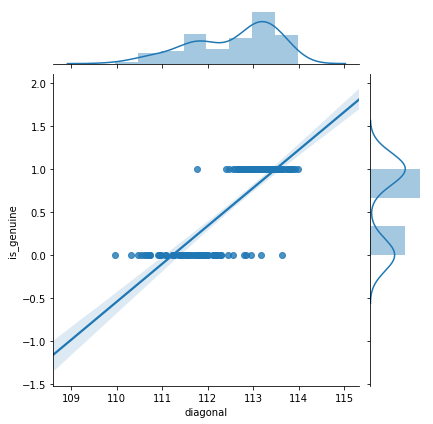

In [15]:
#(some fun)
columns = df_faux_billets.columns[1:7]
for col in columns:
    sns.jointplot(x=df_faux_billets['{}'.format(col)], y=df_faux_billets.is_genuine, kind='reg');

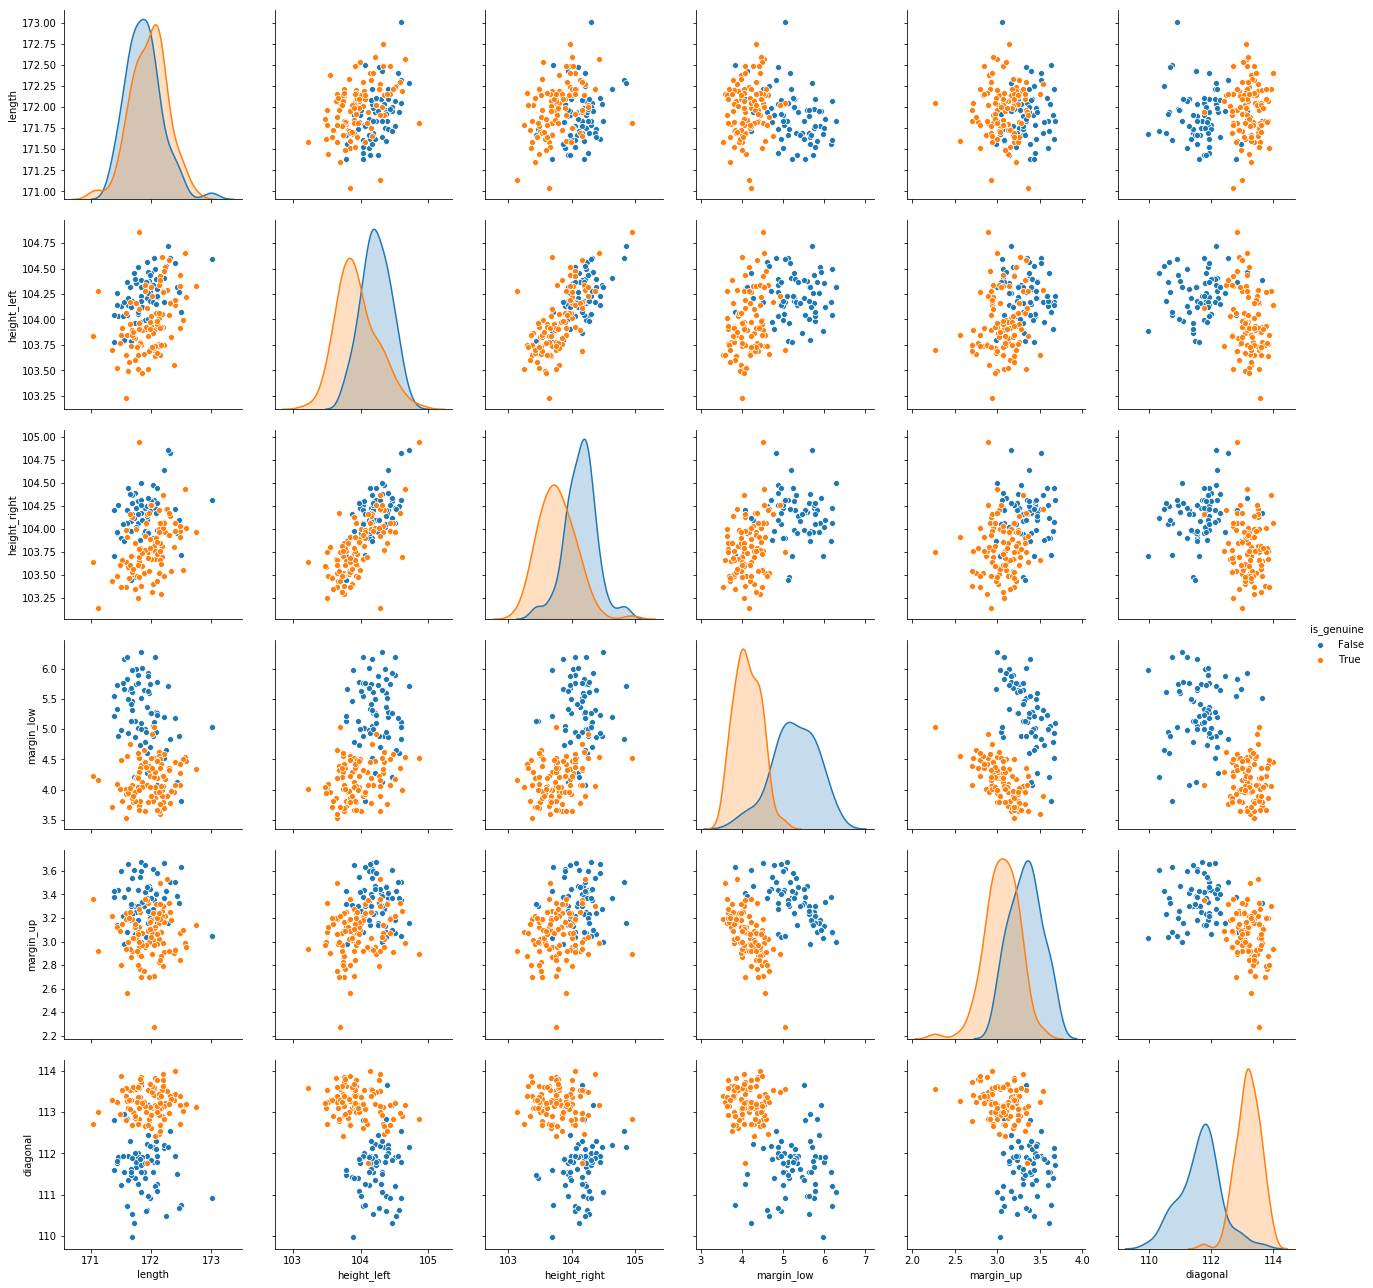

In [16]:

sns.pairplot(df_faux_billets, hue='is_genuine', vars=df_faux_billets.iloc[:,1:7], height=3)
plt.savefig('./graphiques/pairplot.png', dpi=120)

### <font color='green'>Some combinations have good perspectives to distinguish true and false tickets:<font>
-margin_up/margin_low,  
-and each combination with diagonal.

### With the target/explained variable (is_genuine)

#### <font color='red'>Correlation test through variance analysis (ANOVA)<font>

In [17]:
qualitative = 'is_genuine'

quantitative_columns = df_faux_billets.columns[1:7]

In [18]:
quantitative_columns

Index(['length', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'diagonal'],
      dtype='object')

In [19]:
liste_anova=[]

In [20]:
def eta_squared(df,quality,quanti_columns):
    
    for col in quanti_columns:
        classes = []
        moyenne_y = df['{}'.format(col)].mean()
        for classe in df['{}'.format(quality)].unique():
            yi_classe = df['{}'.format(col)][df['{}'.format(quality)]==classe]
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
        SCT = sum([(yj-moyenne_y)**2 for yj in df['{}'.format(col)]])
        SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
        eta = SCE/SCT
        liste_anova.append(eta)
        print('{} et {}:{}'.format(quality,col,eta))

In [21]:
eta_squared(df_faux_billets,'is_genuine', quantitative_columns)

is_genuine et length:0.019383108567068267
is_genuine et height_left:0.21319458315018733
is_genuine et height_right:0.303941546720145
is_genuine et margin_low:0.6401772142887794
is_genuine et margin_up:0.33965670960319944
is_genuine et diagonal:0.6818507654958187


#### statsmodels ANOVA

In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
columns=df_faux_billets.columns[1:]
for col in columns:
    mod = ols('{} ~ is_genuine'.format(col),
              data=df_faux_billets).fit()       
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    liste_anova.append(esq_sm)
    print ('''n² des variables 'is_genuine' et '{}' = {}'''.format(col,esq_sm))

n² des variables 'is_genuine' et 'length' = 0.019383108567106913
n² des variables 'is_genuine' et 'height_left' = 0.2131945831501782
n² des variables 'is_genuine' et 'height_right' = 0.3039415467201628
n² des variables 'is_genuine' et 'margin_low' = 0.6401772142887795
n² des variables 'is_genuine' et 'margin_up' = 0.3396567096031974
n² des variables 'is_genuine' et 'diagonal' = 0.6818507654957879


#### Heatmap de l'ANOVA

In [23]:
gl=[]

In [24]:
if not gl:
    for i in range(0,6,1):
        gl.append(list((columns[i],'is_genuine',liste_anova[i])))

In [25]:
gl

[['length', 'is_genuine', 0.019383108567068267],
 ['height_left', 'is_genuine', 0.21319458315018733],
 ['height_right', 'is_genuine', 0.30394154672014501],
 ['margin_low', 'is_genuine', 0.64017721428877938],
 ['margin_up', 'is_genuine', 0.33965670960319944],
 ['diagonal', 'is_genuine', 0.68185076549581869]]

In [26]:
b = pd.DataFrame(data=gl, columns=['features', 'target_feature', 'anova'])

In [27]:
b = b.pivot("features", "target_feature", "anova")

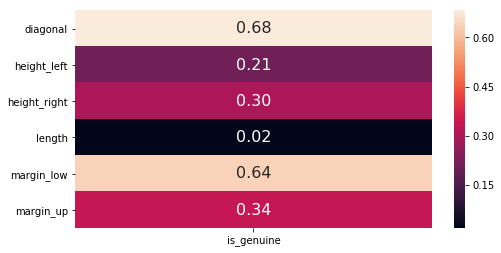

In [28]:
#En plus joli
plt.figure(figsize=(8,4))
sns.heatmap(b, annot=True, fmt=".2f",annot_kws={'size':16})
plt.yticks(rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig('./graphiques/heatmap_anova.png', dpi=120)
plt.show()

# <font color='blue'>PRINCIPAL COMPONENT ANALYSIS (PCA)<font>

### Graphic analysis: to decided how many principal component we will keep

In [29]:
df_faux_billets_CR_features = df_faux_billets_CR.iloc[:,1:7]

In [30]:
nb_line_start=len(df_faux_billets_CR_features)
df_faux_billets_CR_features = df_faux_billets_CR_features.dropna()
nb_line_end=len(df_faux_billets_CR_features)
print('''Rows before drop na_values : {}\nRows after drop na_values : {}'''.format(nb_line_start,nb_line_end))

Rows before drop na_values : 170
Rows after drop na_values : 170


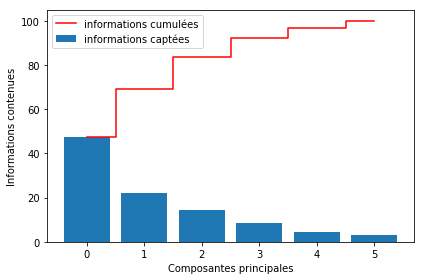

In [31]:
pca = PCA().fit(df_faux_billets_CR_features)
PCs = pca.components_ #Principal axes in feature space, representing the directions of maximum variance in the data.
PCe = pca.explained_variance_ratio_ #Percentage of variance explained by each of the selected variable.
PCsv = pca.singular_values_
PCn = pca.n_components_
PCm = pca.mean_
scree = pca.explained_variance_ratio_*100
cum_scree = np.cumsum(scree)

plt.bar(range(PCn),scree, alpha=1, align='center', label='informations captées')
plt.step(range(PCn), cum_scree, where='mid', label='informations cumulées', color='red')
plt.ylabel('Informations contenues')
plt.xlabel('Composantes principales')
plt.legend(loc='best')
plt.savefig('./graphiques/éboulis.png', dpi=120)
plt.tight_layout()

### Projection

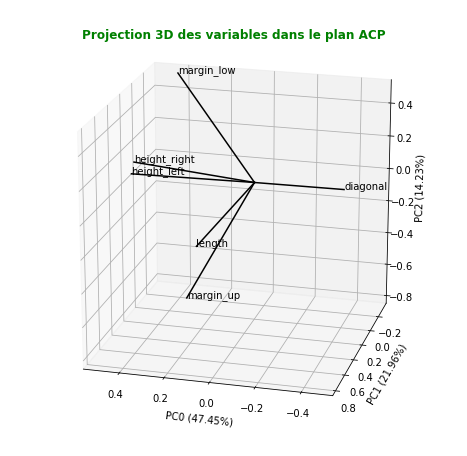

Inertie respective des variables sur les principales composantes:
        length  height_left  height_right  margin_low  margin_up  diagonal
PC0  0.073275     0.475502      0.491821    0.431027   0.352540 -0.465373
PC1  0.779639     0.339250      0.235543   -0.320537  -0.141120  0.314536
PC2 -0.088894     0.122760      0.153830    0.512808  -0.821149  0.126913
PC3 -0.559732     0.278046      0.458938   -0.226528   0.135340  0.573703
PC4 -0.225094     0.715921     -0.486993   -0.311908  -0.193943 -0.254417
PC5  0.122166     0.232131     -0.480813    0.547630   0.354380  0.523951


In [32]:
nrange= len(df_faux_billets_CR_features.columns)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i, (x, y,z) in enumerate(zip(PCs[0, :], PCs[1, :],PCs[2, :])):
    ax.plot([0, x], [0, y],[0,z], color='k')
    ax.text(x,y,z, df_faux_billets_CR_features.columns[i])
ax.view_init(20,105)
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC1 ({:.2f}%)'.format(PCe[1]*100))
ax.set_zlabel('PC2 ({:.2f}%)'.format(PCe[2]*100))
ax.set_title('Projection 3D des variables dans le plan ACP', color='g', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/variables_3D_projection_on_ACP.png', dpi=120)
plt.show()

# Extracting the inertia of the variables on the axes
principalaxes = ['PC{}'.format(i) for i in range(0,len(PCs))]
inertie_variable = pd.DataFrame(np.round(PCs, nrange), columns = df_faux_billets_CR_features.keys())
inertie_variable.index = principalaxes
print('''Inertie respective des variables sur les principales composantes:\n''',inertie_variable)

### 2D Projections (better readability)

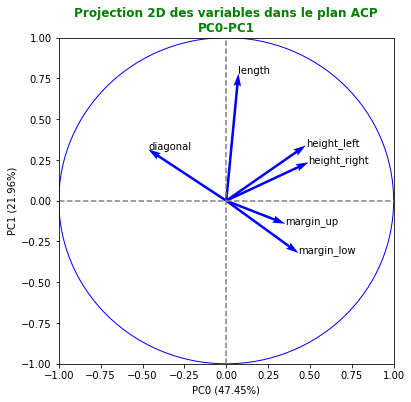

In [33]:
nrange= len(df_faux_billets_CR_features.columns)

fig, ax = plt.subplots(figsize=(6,6))

#features names
for i, (x, y) in enumerate(zip(PCs[0, :], PCs[1, :])):
    ax.text(x,y, df_faux_billets_CR_features.columns[i])

#axis
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC1 ({:.2f}%)'.format(PCe[1]*100))
#correlation circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)
#display h&v lines
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
#arrows
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),PCs[0,:], PCs[1,:], angles='xy', scale_units='xy', scale=1, color="b")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
ax.set_title('Projection 2D des variables dans le plan ACP\nPC0-PC1', color='g', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/variables_2D_projection_on_PC0_PC1.png', dpi=120)
plt.show()

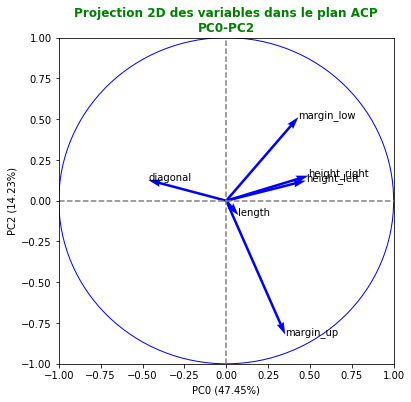

In [34]:
nrange= len(df_faux_billets_CR_features.columns)

fig, ax = plt.subplots(figsize=(6,6))

#features names
for i, (x, y) in enumerate(zip(PCs[0, :], PCs[2, :])):
    ax.text(x,y, df_faux_billets_CR_features.columns[i])

#axis
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC2 ({:.2f}%)'.format(PCe[2]*100))
#correlation circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)
#display h&v lines
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')
#arrows
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),PCs[0,:], PCs[2,:], angles='xy', scale_units='xy', scale=1, color="b")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
ax.set_title('Projection 2D des variables dans le plan ACP\nPC0-PC2', color='g', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/variables_2D_projection_on_PC0_PC2.png', dpi=120)
plt.show()

### 3D final projection

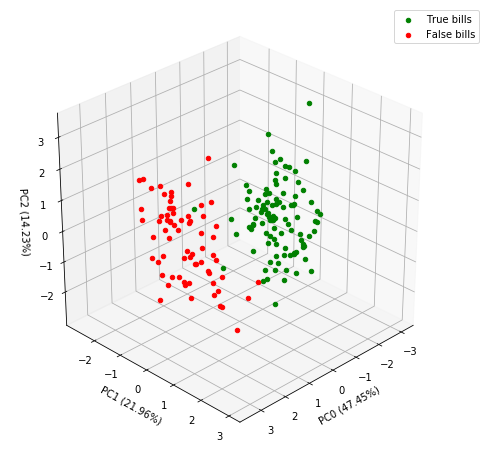

In [35]:
#Coordonates in 3D PCA
pca3 = PCA(n_components=3).fit_transform(df_faux_billets_CR_features)
index = pd.DataFrame(df_faux_billets_CR_features.index)
principal=pd.DataFrame(data=pca3, columns=['PC0', 'PC1','PC2'])
final = pd.concat([principal, index], axis=1)
final = final.set_index(index.columns[0])
final = final.merge(df_faux_billets[['is_genuine']], right_index=True, left_index=True)

#Projection in PCA plan
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for x, y,z,b in zip(final.PC0,final.PC1,final.PC2,final['is_genuine']):
    if b == 1:
        vrais = ax.scatter(x,y,z, color='g')

    elif b == 0:
        faux = ax.scatter(x,y,z, color='r')
ax.view_init(30,45)        
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC1 ({:.2f}%)'.format(PCe[1]*100))
ax.set_zlabel('PC2 ({:.2f}%)'.format(PCe[2]*100))
plt.legend((vrais, faux), ('True bills', 'False bills'),bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.savefig('./graphiques/boolean_ACP_3D_projection.png', dpi=120)
plt.show()

In [36]:
#coordonates in 3D PCA
final.head()

,PC0,PC1,PC2,is_genuine
0,,,,
0,2.147295,1.594997,1.782186,True
1,-2.104200,-0.524489,0.540965,True
2,-1.967340,-0.047960,0.856186,True
3,-2.053728,-0.088843,-0.529963,True
4,-2.396101,0.410956,3.309730,True


### Quality of repartition (from PCA) analysis

In [37]:
#PCA centroides extraction
final1_mean_PC0 = final.PC0[final['is_genuine'].isin({1})].mean()
final1_mean_PC1 = final.PC1[final['is_genuine'].isin({1})].mean()
final1_mean_PC2 = final.PC2[final['is_genuine'].isin({1})].mean()
final0_mean_PC0 = final.PC0[final['is_genuine'].isin({0})].mean()
final0_mean_PC1 = final.PC1[final['is_genuine'].isin({0})].mean()
final0_mean_PC2 = final.PC2[final['is_genuine'].isin({0})].mean()

In [38]:
comparaison_finale = pd.DataFrame({'PC0':[final1_mean_PC0,final0_mean_PC0],'PC1':[final1_mean_PC1,final0_mean_PC1],'PC2':[final1_mean_PC2,final0_mean_PC2]})
comparaison_finale=comparaison_finale.reset_index()
comparaison_finale = comparaison_finale.rename(columns={'index':'boolean'})

In [39]:
comparaison_finale

,boolean,PC0,PC1,PC2
0,0,-1.180475,0.350763,0.016012
1,1,1.686392,-0.501091,-0.022875


In [40]:
#Calculation of the Euclidean distance between each ticket and the (True/False) centroids determined by the PCA.
#And finaly to know which group the PCA has affiliated each ticket to compare the distribution made by the CPA
#to the actual distribution (true / false)
comparaison_final_ACP = final[['PC0','PC1','PC2','is_genuine']].copy()

In [41]:
comparaison_final_ACP['distance_to_centro_true'] = np.sqrt((comparaison_final_ACP['PC0']-final1_mean_PC0)**2+(comparaison_final_ACP['PC1']-final1_mean_PC1)**2+(comparaison_final_ACP['PC2']-final1_mean_PC2)**2)
comparaison_final_ACP['distance_to_centro_false'] = np.sqrt((comparaison_final_ACP['PC0']-final0_mean_PC0)**2+(comparaison_final_ACP['PC1']-final0_mean_PC1)**2+(comparaison_final_ACP['PC2']-final0_mean_PC2)**2)

In [42]:
comparaison_final_ACP.head()

,PC0,PC1,PC2,is_genuine,distance_to_centro_true,distance_to_centro_false
0,,,,,,
0,2.147295,1.594997,1.782186,True,3.967561,2.804329
1,-2.104200,-0.524489,0.540965,True,1.376557,3.832369
2,-1.967340,-0.047960,0.856186,True,1.218208,3.785213
3,-2.053728,-0.088843,-0.529963,True,1.119783,3.796786
4,-2.396101,0.410956,3.309730,True,3.511402,5.348349


In [43]:
#distinguish the true bills from the fake bills
good_repartition=0
bad_repartition=0
for gen,centro_true,centro_false in zip(comparaison_final_ACP['is_genuine'],comparaison_final_ACP['distance_to_centro_true'],comparaison_final_ACP['distance_to_centro_false']):
    if gen==True and centro_true < centro_false:
        good_repartition = good_repartition +1
    if gen==True and centro_true > centro_false:
        bad_repartition = bad_repartition +1
    if gen==False and centro_true > centro_false:
        good_repartition = good_repartition +1
    if gen==False and centro_true < centro_false:
        bad_repartition = bad_repartition +1
    result_ACP = pd.DataFrame({'predictions_justes':good_repartition,'predictions_fausses':bad_repartition},index=[0,1])
result_ACP

,predictions_justes,predictions_fausses
0,163,7
1,163,7


### Analysis of Variance (ANOVA) between principal components and explained variable

In [44]:
columns = final.columns[0:3]

In [45]:
liste_anova=list()

In [46]:
columns=final.columns[:3]
for col in columns:
    mod = ols('{} ~ is_genuine'.format(col),
              data=final).fit()       
    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    liste_anova.append(esq_sm)
    print ('''n² des variables 'is_genuine' et '{}' = {}'''.format(col,esq_sm))

n² des variables 'is_genuine' et 'PC0' = 0.7034108677037673
n² des variables 'is_genuine' et 'PC1' = 0.13420435505390907
n² des variables 'is_genuine' et 'PC2' = 0.00043139978813614837


#### <font color='green'>Corrélation avec PC0 (axe comptenant le plus d'informations) qui est composée par toutes les variables sauf 'length' de façon assez équilibrée (rapport à leur inertie sur cet axe).<font>

#### Heatmap (ANOVA: principal components and explained variable)

In [47]:
gl = []

In [48]:
if not gl:
    for i in range(0,3,1):
        gl.append(list((columns[i],'is_genuine',liste_anova[i])))
b = pd.DataFrame(data=gl, columns=['features', 'target_feature', 'anova'])
b = b.pivot("features", "target_feature", "anova")

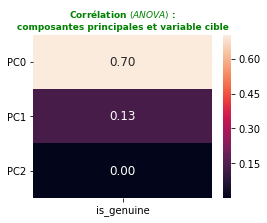

In [49]:
plt.figure(figsize=(4,3))
sns.heatmap(b, annot=True, fmt=".2f",annot_kws={'size':12})
plt.yticks(rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.title('''Corrélation $(ANOVA)$ :\ncomposantes principales et variable cible''', color = 'g', fontsize=9,fontweight='bold')
plt.savefig('./graphiques/heatmap_anova_ACP.png', dpi=120)
plt.show()

### Quality of representation (individuals in ACP)

In [50]:
#quality in each principal component
final['Qlt_on_PC0'] = (final['PC0']**2)/((final['PC0']**2)+(final['PC1']**2)+(final['PC2']**2))
final['Qlt_on_PC1'] = (final['PC1']**2)/((final['PC0']**2)+(final['PC1']**2)+(final['PC2']**2))
final['Qlt_on_PC2'] = (final['PC2']**2)/((final['PC0']**2)+(final['PC1']**2)+(final['PC2']**2))

In [51]:
final.head()

,PC0,PC1,PC2,is_genuine,Qlt_on_PC0,Qlt_on_PC1,Qlt_on_PC2
0,,,,,,,
0,2.147295,1.594997,1.782186,True,0.446311,0.246249,0.307440
1,-2.104200,-0.524489,0.540965,True,0.886349,0.055069,0.058583
2,-1.967340,-0.047960,0.856186,True,0.840341,0.000499,0.159160
3,-2.053728,-0.088843,-0.529963,True,0.935926,0.001751,0.062323
4,-2.396101,0.410956,3.309730,True,0.340437,0.010014,0.649549


### Contribution of each bill to inertia

#### <font color='green'>Axes total inertia<font>

In [52]:
inertie_PC0 = pca.explained_variance_[0]
inertie_PC1 = pca.explained_variance_[1]
inertie_PC2 = pca.explained_variance_[2]

#### <font color='green'>Ticket's inertia<font>

In [53]:
nb_individus = len(final)

In [54]:
final['Ctr_on_PC0'] = (final.PC0**2/nb_individus)/inertie_PC0
final['Ctr_on_PC1'] = (final.PC1**2/nb_individus)/inertie_PC1
final['Ctr_on_PC2'] = (final.PC2**2/nb_individus)/inertie_PC2

In [55]:
#Results
final.head()

,PC0,PC1,PC2,is_genuine,Qlt_on_PC0,Qlt_on_PC1,Qlt_on_PC2,Ctr_on_PC0,Ctr_on_PC1,Ctr_on_PC2
0,,,,,,,,,,
0,2.147295,1.594997,1.782186,True,0.446311,0.246249,0.307440,0.009527,0.011359,0.021876
1,-2.104200,-0.524489,0.540965,True,0.886349,0.055069,0.058583,0.009149,0.001228,0.002016
2,-1.967340,-0.047960,0.856186,True,0.840341,0.000499,0.159160,0.007997,0.000010,0.005049
3,-2.053728,-0.088843,-0.529963,True,0.935926,0.001751,0.062323,0.008715,0.000035,0.001934
4,-2.396101,0.410956,3.309730,True,0.340437,0.010014,0.649549,0.011863,0.000754,0.075447


### Huge inertia individuals detection

In [56]:
nb_individus = len(final)
Ctr_columns = list(final.columns[6:9])
list_individus=list(np.arange(0,len(final),1))
list_coeff=[]
list_bills=[]
list_percent_inertia=[]
list_axis=[]
list_mean_inertia=[]
list_inertia=[]

for i,col in ittls.product(list_individus,Ctr_columns):
    inertie = final['{}'.format(col)][i]
    inertie_totale = final['{}'.format(col)].sum() 
    mean_inertie = inertie_totale/nb_individus
    coeff = inertie/mean_inertie
    nb_billet = i
    if coeff>3: #considering inertia > 3* mean inertia
        axe = col[7:10]
        percent = 100*(inertie/inertie_totale)
        list_coeff.append(coeff)
        list_bills.append(nb_billet)
        list_percent_inertia.append(percent)
        list_axis.append(axe)
        list_inertia.append(inertie)
        list_mean_inertia.append(mean_inertie)

In [57]:
for x in (list_coeff,list_bills,list_inertia,list_percent_inertia,list_axis,list_mean_inertia):
    print(len(x))

32
32
32
32
32
32


In [58]:
df_inertia_contribute = pd.DataFrame({'BILLS':list_bills,'INERTIA':list_inertia,'AXIS':list_axis,'mean_inertia':list_mean_inertia,'mean_coeff':list_coeff,'inertia_percent':list_percent_inertia})

In [59]:
df_inertia_contribute

,BILLS,INERTIA,AXIS,mean_inertia,mean_coeff,inertia_percent
0,4,0.649549,PC2,0.179786,3.612895,2.125233
1,5,0.039503,PC1,0.005848,6.755163,3.973625
2,15,0.589684,PC2,0.179786,3.279918,1.929364
3,18,0.665777,PC2,0.179786,3.703163,2.178331
4,21,0.025003,PC1,0.005848,4.275699,2.515117
5,23,0.023542,PC1,0.005848,4.025893,2.368173
6,26,0.019053,PC1,0.005848,3.258201,1.916589
7,27,0.712496,PC2,0.179786,3.963021,2.331189
8,29,0.017982,PC0,0.005848,3.075095,1.808879
9,33,0.018444,PC1,0.005848,3.153956,1.855268


### Graphic projections:  
-quality of individual representations,  
-individual total inertia contribution

In [60]:
finalplot = final.copy()
finalplot = finalplot.reset_index()

In [61]:
finalplot = finalplot.rename(columns={0:'n_billet'})

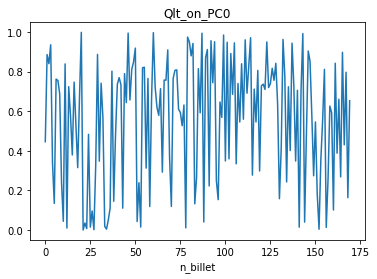

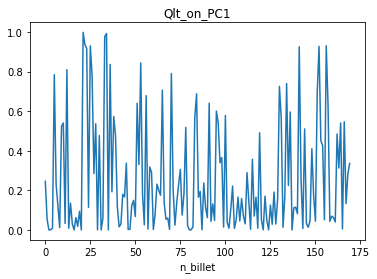

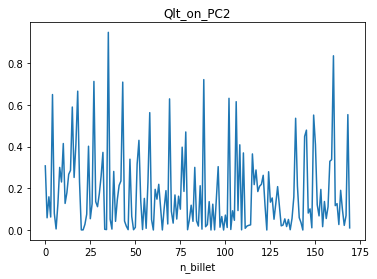

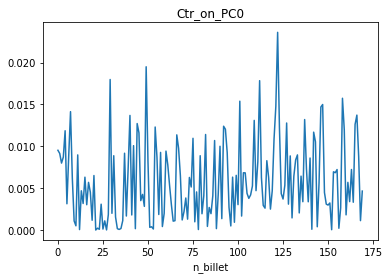

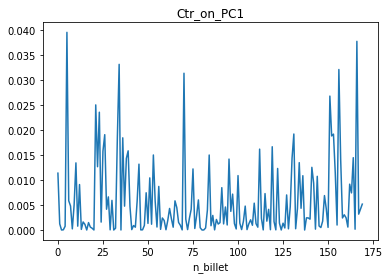

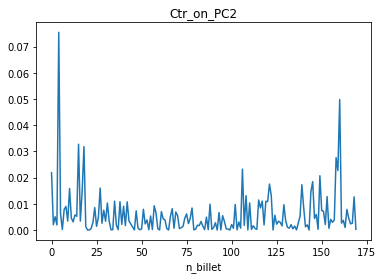

In [62]:
%matplotlib inline
columns = final.columns[4:10]
num_billets=list(final.index)
for col in columns[0:3]:
    finalplot.plot(x='n_billet', y=col, legend=False)
    plt.title('{}'.format(col))
    plt.savefig('./graphiques/qualité_représentation_{}.png'.format(col[4:10]), dpi=120)
for col in columns[3:7]:
    finalplot.plot(x='n_billet', y=col, legend=False)
    plt.title('{}'.format(col))
    plt.savefig('./graphiques/contribution_inertie_{}.png'.format(col[4:10]), dpi=120)
plt.show()

### Contribution

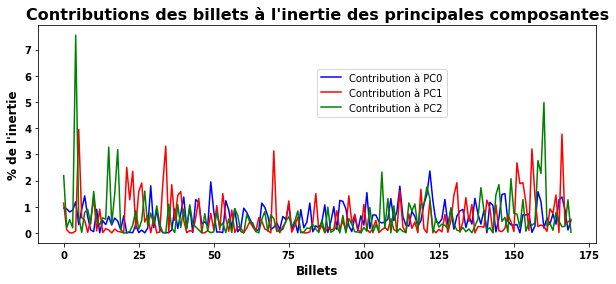

In [63]:
plt.figure(figsize=(10, 4))

x=final.index
y1=final.Ctr_on_PC0*100
y2=final.Ctr_on_PC1*100
y3=final.Ctr_on_PC2*100

plt.plot(x,y1,'b-', x, y2, 'r-', x,y3,'g-')
plt.legend(['Contribution à PC0','Contribution à PC1','Contribution à PC2'], loc=(0.50,0.58))
plt.ylabel('''% de l'inertie''', fontsize=12, fontweight='bold')
plt.xlabel('Billets', fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('''Contributions des billets à l'inertie des principales composantes''', fontsize=16, fontweight='bold')

plt.savefig('./graphiques/billets_inerties_ACP.png', dpi=120)
plt.show()

#### Does target variable have a correlation with the contribution to the inertia?

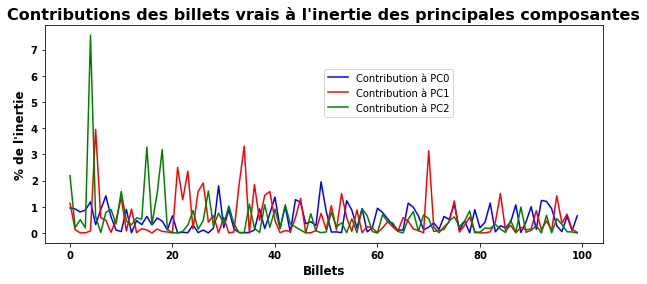

In [64]:
final_true=final[final['is_genuine']==True]
plt.figure(figsize=(10, 4))

x=final_true.index
y1=final_true.Ctr_on_PC0*100
y2=final_true.Ctr_on_PC1*100
y3=final_true.Ctr_on_PC2*100

plt.plot(x,y1,'b-', x, y2, 'r-', x,y3,'g-')
plt.legend(['Contribution à PC0','Contribution à PC1','Contribution à PC2'], loc=(0.50,0.58))
plt.ylabel('''% de l'inertie''', fontsize=12, fontweight='bold')
plt.xlabel('Billets', fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('''Contributions des billets vrais à l'inertie des principales composantes''', fontsize=16, fontweight='bold')

#plt.savefig('./graphiques/billets_vrais_inerties_ACP.png', dpi=120)
plt.show()

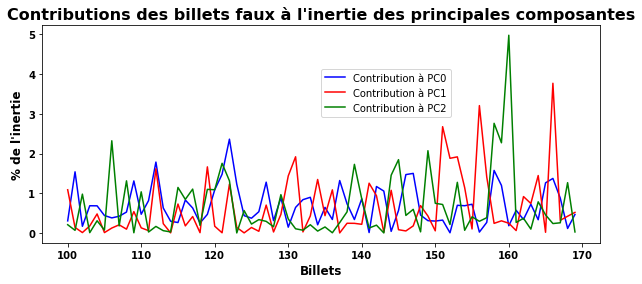

In [65]:
final_false=final[final['is_genuine']==False]
plt.figure(figsize=(10, 4))

x=final_false.index
y1=final_false.Ctr_on_PC0*100
y2=final_false.Ctr_on_PC1*100
y3=final_false.Ctr_on_PC2*100

plt.plot(x,y1,'b-', x, y2, 'r-', x,y3,'g-')
plt.legend(['Contribution à PC0','Contribution à PC1','Contribution à PC2'], loc=(0.50,0.58))
plt.ylabel('''% de l'inertie''', fontsize=12, fontweight='bold')
plt.xlabel('Billets', fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('''Contributions des billets faux à l'inertie des principales composantes''', fontsize=16, fontweight='bold')

#plt.savefig('./graphiques/billets_vrais_inerties_ACP.png', dpi=120)
plt.show()

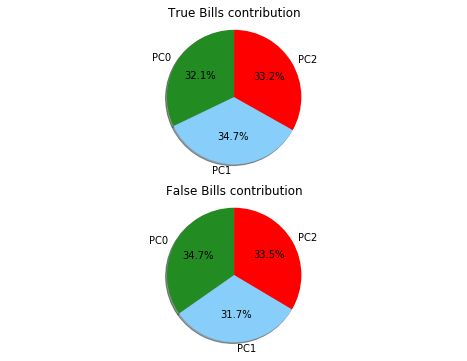

In [66]:
labels = 'PC0', 'PC1', 'PC2'
sizes_false = [final_false.Ctr_on_PC0.sum(),final_false.Ctr_on_PC1.sum(),final_false.Ctr_on_PC2.sum()]
sizes_true = [final_true.Ctr_on_PC0.sum(),final_true.Ctr_on_PC1.sum(),final_true.Ctr_on_PC2.sum()]
colors = ['forestgreen', 'lightskyblue', 'red']

plt.figure(figsize=(8, 6)) 

plt.subplot(211)
plt.pie(sizes_true, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('''True Bills contribution''')
plt.axis('equal')


plt.subplot(212)
plt.pie(sizes_false, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('''False Bills contribution''')
plt.axis('equal')

#plt.savefig()
plt.show()

### Individual representation quality

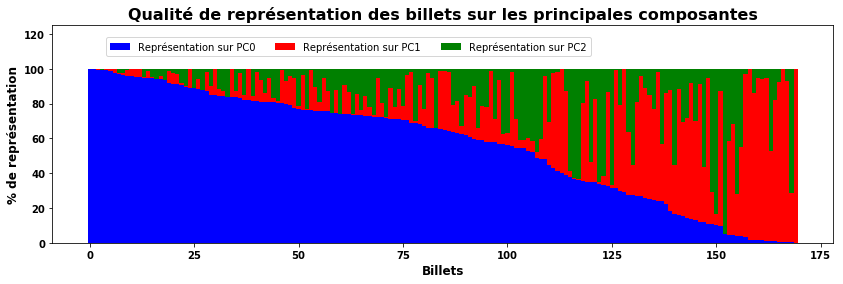

In [67]:
final_sorted = final.sort_values(by=['Qlt_on_PC0' ],ascending=False)
plt.figure(figsize=(14, 4))

x=np.arange(0,170,1)
y1=final_sorted.Qlt_on_PC0*100
y2=final_sorted.Qlt_on_PC1*100
y3=final_sorted.Qlt_on_PC2*100

width=1
p1 = plt.bar(x, y1,width, color=['b'])
p2 = plt.bar(x, y2,width,  bottom=y1,color=['r'])
p3 = plt.bar(x, y3,width,  bottom=y1+y2,color=['g'])

plt.legend(['Représentation sur PC0','Représentation sur PC1','Représentation sur PC2'], loc=(0.069,0.86),ncol=3)
plt.ylabel('''% de représentation''', fontsize=12, fontweight='bold')
plt.xlabel('Billets', fontsize=12, fontweight='bold')
plt.ylim(0,125)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('''Qualité de représentation des billets sur les principales composantes''', fontsize=16, fontweight='bold')

plt.savefig('./graphiques/billets_représentation_ACP.png', dpi=120)
plt.show()

In [68]:
Rpt_on_PC0 = 100*final.Qlt_on_PC0.sum()/170
Rpt_on_PC1 = 100*final.Qlt_on_PC1.sum()/170
Rpt_on_PC2 = 100*final.Qlt_on_PC2.sum()/170
print('''La composante principale PC0 capte {:.2f}% de la représentation des billets.\n
La composante principale PC0 capte {:.2f}% de la représentation des billets.\n
La composante principale PC0 capte {:.2f}% de la représentation des billets.\n'''.format(Rpt_on_PC0,Rpt_on_PC1,Rpt_on_PC2))

La composante principale PC0 capte 56.23% de la représentation des billets.

La composante principale PC0 capte 25.79% de la représentation des billets.

La composante principale PC0 capte 17.98% de la représentation des billets.



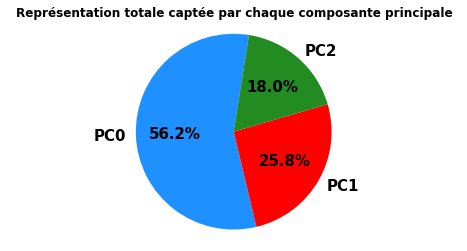

In [69]:
plt.figure(figsize=(8, 4))
names = ['PC0', 'PC1', 'PC2']
fracs = [Rpt_on_PC0, Rpt_on_PC1, Rpt_on_PC2]
colors = ['dodgerblue', 'r', 'forestgreen']
plt.pie(fracs, labels=names, colors=colors, autopct='%1.1f%%', shadow=False, startangle=81,textprops={'fontsize': 15,'fontweight':'bold', 'color':'black'})
plt.axis('equal')
plt.title('''Représentation totale captée par chaque composante principale''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/camembert_qualite_representation.png', dpi=150)
plt.show()

#### Does is_genuine has an signigicant impact? -> Do we have a good repartition of tickets true/false on PCA axes?

In [70]:
Rpt_on_PC0_true = 100*final_true.Qlt_on_PC0.sum()/len(final_true)
Rpt_on_PC1_true = 100*final_true.Qlt_on_PC1.sum()/len(final_true)
Rpt_on_PC2_true = 100*final_true.Qlt_on_PC2.sum()/len(final_true)
Rpt_on_PC0_false = 100*final_false.Qlt_on_PC0.sum()/len(final_false)
Rpt_on_PC1_false = 100*final_false.Qlt_on_PC1.sum()/len(final_false)
Rpt_on_PC2_false = 100*final_false.Qlt_on_PC2.sum()/len(final_false)

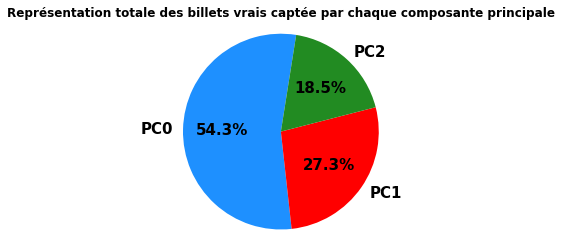

In [71]:
plt.figure(figsize=(8, 4))
names = ['PC0', 'PC1', 'PC2']
fracs = [Rpt_on_PC0_true, Rpt_on_PC1_true, Rpt_on_PC2_true]
colors = ['dodgerblue', 'r', 'forestgreen']
plt.pie(fracs, labels=names, colors=colors, autopct='%1.1f%%', shadow=False, startangle=81,textprops={'fontsize': 15,'fontweight':'bold', 'color':'black'})
plt.axis('equal')
plt.title('''Représentation totale des billets vrais captée par chaque composante principale''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/camembert_qualite_representation_true.png', dpi=150)
plt.show()

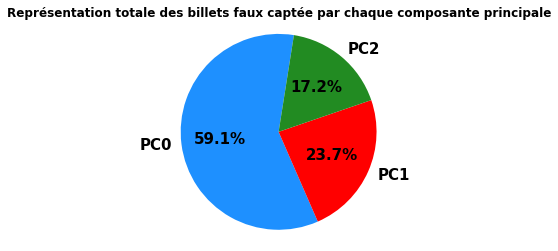

In [72]:
plt.figure(figsize=(8, 4))
names = ['PC0', 'PC1', 'PC2']
fracs = [Rpt_on_PC0_false, Rpt_on_PC1_false, Rpt_on_PC2_false]
colors = ['dodgerblue', 'r', 'forestgreen']
plt.pie(fracs, labels=names, colors=colors, autopct='%1.1f%%', shadow=False, startangle=81,textprops={'fontsize': 15,'fontweight':'bold', 'color':'black'})
plt.axis('equal')
plt.title('''Représentation totale des billets faux captée par chaque composante principale''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/camembert_qualite_representation_false.png', dpi=150)
plt.show()

#### Few ouliers (aspecialy on PC1 and PC2), nothing really significant bu we can drop them if needed.

In [73]:
outliers_PC1 = list(final.index[final['Ctr_on_PC1']>0.025])
df_faux_billets[df_faux_billets.index.isin(outliers_PC1)]

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
5,True,172.57,104.65,104.44,4.54,2.99,113.16
21,True,172.49,104.44,103.98,4.08,3.07,113.16
34,True,172.75,104.33,103.97,4.34,3.14,113.12
70,True,171.04,103.84,103.64,4.22,3.36,112.70
151,False,171.68,103.89,103.70,5.97,3.03,109.97
156,False,171.38,103.78,103.70,5.22,3.43,111.60
166,False,173.01,104.59,104.31,5.04,3.05,110.91


In [74]:
outliers_PC2 = list(final.index[final['Ctr_on_PC2']>0.04])
df_faux_billets[df_faux_billets.index.isin(outliers_PC2)]

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
4,True,172.05,103.70,103.75,5.04,2.27,113.55
160,False,172.50,104.07,103.71,3.82,3.63,110.74


# <font color='blue'>CLASSIFICATION (KMEANS)<font>
#### <font color='red'>(standardized data)<font>

In [75]:
from sklearn.cluster import KMeans

In [76]:
#wihtout explained variable
df_faux_billet_kmeans=df_faux_billets_CR.drop('is_genuine', axis=1).copy()

kmeans = KMeans(n_clusters=2, random_state=17)  
kmeans.fit(df_faux_billet_kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

In [77]:
#Centroides coordonates (in initial plan)<
print(kmeans.cluster_centers_)  

[[ 0.06383311 -0.52006716 -0.57929341 -0.67728258 -0.50853912  0.72764871]
 [-0.07895147  0.64324096  0.71649448  0.83769161  0.62898259 -0.89998656]]


In [78]:
#DataFrame contenant les centroïdes
df_centroides_cluster_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=list(df_faux_billets_CR.columns[1:7]))

In [79]:
#Répartition résultant du Kmeans
print(kmeans.labels_)

[1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [80]:
#DataFrame des résultats du Kmeans
df_result_kmeans = pd.DataFrame(kmeans.labels_, columns={'cluster_kmeans'})

In [81]:
#Merge to analyze the quality of the repartition
df_compare_result_kmeans = df_result_kmeans.merge(df_faux_billets_CR, right_index=True, left_index=True)
df_compare_result_kmeans.head()

,cluster_kmeans,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,1,True,-0.427082,2.661591,3.087442,-0.131203,-1.186369,0.280804
1,0,True,-0.884945,-1.094464,-0.689218,-0.857592,-1.270985,0.778398
2,0,True,-0.361673,-1.027391,-0.507939,-0.302118,-1.228677,1.373347
3,0,True,-0.459787,-0.960319,-0.840285,-1.256394,-0.213283,1.146185
4,0,True,0.357826,-1.228609,-0.538152,0.609430,-3.809471,1.059647


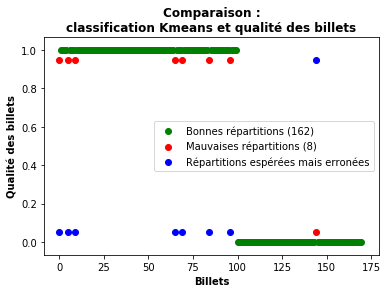

In [82]:
error=0
for i,predicting, testing in zip(df_compare_result_kmeans.index,df_compare_result_kmeans.cluster_kmeans,df_compare_result_kmeans.is_genuine):
    if predicting==0 and testing==True:
        good_pred = plt.scatter(x=i, y = 1, c='g')
    elif predicting==1 and testing==False:
        good_pred = plt.scatter(x=i, y = 0, c='g')
    elif predicting==0 and testing==False:
        wrong_pred = plt.scatter(x=i, y = 0.05, c='r')
        expected_pred = plt.scatter(x=i, y = 0.95, c='b')
        error=error+1
    elif predicting==1 and testing==True:
        wrong_pred = plt.scatter(x=i, y = 0.95, c='r')
        expected_pred = plt.scatter(x=i, y = 0.05, c='b')
        error=error+1
if error!=0:
    plt.legend((good_pred, wrong_pred, expected_pred), ('Bonnes répartitions ({})'.format(len(df_compare_result_kmeans)-error), 'Mauvaises répartitions ({})'.format(error), 'Répartitions espérées mais erronées'))
elif error==0:
    plt.legend(['Toutes les répartitions sont bonnes ({})'.format(len(df_compare_result_kmeans))])


plt.xlabel('Billets', fontsize=10, fontweight='bold')
plt.ylabel('Qualité des billets', fontsize=10, fontweight='bold')
plt.title('Comparaison :\nclassification Kmeans et qualité des billets', fontweight='bold')
plt.savefig('./graphiques/result_kmeans_predicting.png', dpi=120)
plt.show()

### Analysis of k-means repartition in first ACP plan

In [83]:
df_centroides_cluster_kmeans= df_centroides_cluster_kmeans.reset_index()

In [84]:
df_centroides_cluster_kmeans = df_centroides_cluster_kmeans.rename(columns={'index':'cluster'})

In [85]:
df_centroides_cluster_kmeans

,cluster,length,height_left,height_right,margin_low,margin_up,diagonal
0,0,0.063833,-0.520067,-0.579293,-0.677283,-0.508539,0.727649
1,1,-0.078951,0.643241,0.716494,0.837692,0.628983,-0.899987


In [86]:
# Cluster centroides coordonates in PCA plan
# (extract features iniertiate in PCA)
df_centroides_cluster_kmeans['PC0'] = df_centroides_cluster_kmeans['length']*PCs[0,0]+df_centroides_cluster_kmeans['height_left']*PCs[0,1]+df_centroides_cluster_kmeans['height_right']*PCs[0,2]+df_centroides_cluster_kmeans['margin_low']*PCs[0,3]+df_centroides_cluster_kmeans['margin_up']*PCs[0,4]+df_centroides_cluster_kmeans['diagonal']*PCs[0,5]
df_centroides_cluster_kmeans['PC1'] = df_centroides_cluster_kmeans['length']*PCs[1,0]+df_centroides_cluster_kmeans['height_left']*PCs[1,1]+df_centroides_cluster_kmeans['height_right']*PCs[1,2]+df_centroides_cluster_kmeans['margin_low']*PCs[1,3]+df_centroides_cluster_kmeans['margin_up']*PCs[1,4]+df_centroides_cluster_kmeans['diagonal']*PCs[1,5]
df_centroides_cluster_kmeans['PC2'] = df_centroides_cluster_kmeans['length']*PCs[2,0]+df_centroides_cluster_kmeans['height_left']*PCs[2,1]+df_centroides_cluster_kmeans['height_right']*PCs[2,2]+df_centroides_cluster_kmeans['margin_low']*PCs[2,3]+df_centroides_cluster_kmeans['margin_up']*PCs[2,4]+df_centroides_cluster_kmeans['diagonal']*PCs[2,5]

In [87]:
df_centroides_cluster_kmeans

,cluster,length,height_left,height_right,margin_low,margin_up,diagonal,PC0,PC1,PC2
0,0,0.063833,-0.520067,-0.579293,-0.677283,-0.508539,0.727649,-1.337360,0.254617,0.003988
1,1,-0.078951,0.643241,0.716494,0.837692,0.628983,-0.899987,1.654103,-0.314921,-0.004933


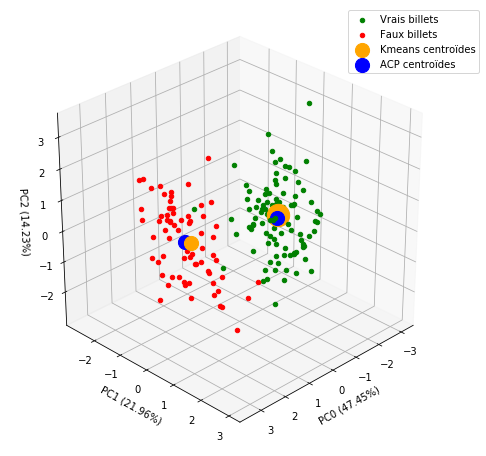

In [88]:
#Projection des centroïdes des 2 groupes kmeans dans le plan 3D ACP (avec notre échantillon initial)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

#Tickets
for x, y,z,b in zip(final.PC0,final.PC1,final.PC2,final['is_genuine']):
    if b == 1:
        vrais = ax.scatter(x,y,z, color='g')

    elif b == 0:
        faux = ax.scatter(x,y,z, color='r')
#Custers centroide from Kmeans
for xc,yc,zc,bc in zip(df_centroides_cluster_kmeans.PC0,df_centroides_cluster_kmeans.PC1,df_centroides_cluster_kmeans.PC2,df_centroides_cluster_kmeans['cluster']):
    if bc == 1:
        cluster1 = ax.scatter(xc,yc,zc, color='orange', s=200)

    elif bc == 0:
        cluster2 = ax.scatter(xc,yc,zc, color='orange', s=500)
#Clusters centroide (True & False) in PCA
for xd,yd,zd,bd in zip(comparaison_finale.PC0,comparaison_finale.PC1,comparaison_finale.PC2,comparaison_finale['boolean']):
    if bd == 1:
        ACP_centro1 = ax.scatter(xd,yd,zd, color='blue', s=200)

    elif bd == 0:
        ACP_centro0 = ax.scatter(xd,yd,zd, color='blue', s=200)
ax.view_init(30,45)        
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC1 ({:.2f}%)'.format(PCe[1]*100))
ax.set_zlabel('PC2 ({:.2f}%)'.format(PCe[2]*100))
plt.legend((vrais, faux, cluster1, ACP_centro1), ('Vrais billets', 'Faux billets','Kmeans centroïdes', 'ACP centroïdes'),bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.savefig('./graphiques/boolean_&_kmeans_ACP_3D_projection.png', dpi=120)
plt.show()

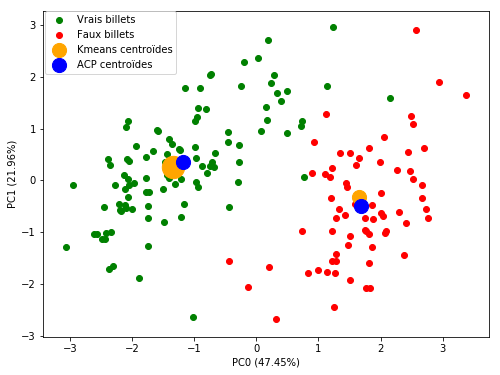

In [89]:
#Projection des centroïdes des 2 groupes kmeans dans le plan 2D ACP (avec notre échantillon initial)
fig, ax = plt.subplots(figsize=(8,6))

#Billets
for x, y,b in zip(final.PC0,final.PC1,final['is_genuine']):
    if b == 1:
        vrais = ax.scatter(x,y, color='g')

    elif b == 0:
        faux = ax.scatter(x,y, color='r')
#Custers centroide from Kmeans
for xc,yc,bc in zip(df_centroides_cluster_kmeans.PC0,df_centroides_cluster_kmeans.PC1,df_centroides_cluster_kmeans['cluster']):
    if bc == 1:
        cluster1 = ax.scatter(xc,yc, color='orange', s=200)

    elif bc == 0:
        cluster2 = ax.scatter(xc,yc, color='orange', s=500)
#Clusters centroide (True & False) in PCA
for xd,yd,bd in zip(comparaison_finale.PC0,comparaison_finale.PC1,comparaison_finale['boolean']):
    if bd == 1:
        ACP_centro1 = ax.scatter(xd,yd, color='blue', s=200)

    elif bd == 0:
        ACP_centro0 = ax.scatter(xd,yd, color='blue', s=200)       
ax.set_xlabel('PC0 ({:.2f}%)'.format(PCe[0]*100))
ax.set_ylabel('PC1 ({:.2f}%)'.format(PCe[1]*100))
plt.legend((vrais, faux, cluster1, ACP_centro1), ('Vrais billets', 'Faux billets','Kmeans centroïdes', 'ACP centroïdes'),bbox_to_anchor=(0.299, 0.999), borderaxespad=0.)
plt.savefig('./graphiques/boolean_&_kmeans_ACP_2D_projection.png', dpi=120)
plt.show()

In [90]:
#somme des distances de chaque individu par rapport au centroïde du cluster auquel il est attribué
kmeans.inertia_

623.55777059496768

# <font color='blue'>LOGISTIC REGRESSION<font>

### Samples (test/train)

In [91]:
#Matrix
matrix_faux_billets = df_faux_billets_CR.as_matrix(df_faux_billets_CR.columns[1:7])

etiquettes_faux_billets = df_faux_billets_CR.as_matrix([df_faux_billets_CR.columns[0]])
etiquettes_faux_billets = etiquettes_faux_billets.flatten() #retourne un array en 1 dimension [0],[0],[1] -> [0,0,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [92]:
#Separate True and False tickets
etiquettes_faux_billets_class = np.where(etiquettes_faux_billets < 1, 0, 1)

In [93]:
#extract training and testing data
faux_billets_train, faux_billets_test, etiquettes_faux_billets_train, etiquettes_faux_billets_test = model_selection.train_test_split(matrix_faux_billets, etiquettes_faux_billets_class,test_size=0.3)

In [94]:
faux_billets_train.shape

(119, 6)

In [95]:
faux_billets_test.shape

(51, 6)

In [96]:
etiquettes_faux_billets_train.shape

(119,)

In [97]:
etiquettes_faux_billets_test.shape

(51,)

### Training data projection (to check balance samples)

In [98]:
df_etiquettes_faux_billets_train = pd.DataFrame({'boolean_train':etiquettes_faux_billets_train})

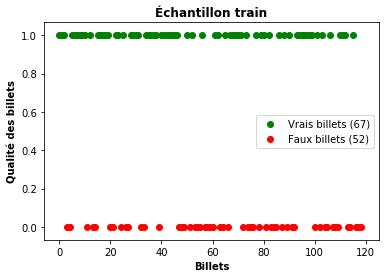

In [99]:
%matplotlib inline
n_vrais = len(df_etiquettes_faux_billets_train[df_etiquettes_faux_billets_train['boolean_train'].isin({1})])
n_faux = len(df_etiquettes_faux_billets_train[df_etiquettes_faux_billets_train['boolean_train'].isin({0})])
for i,ii in zip(df_etiquettes_faux_billets_train.index, df_etiquettes_faux_billets_train.boolean_train):
    if ii==1:
        vrais = plt.scatter(x=i,y=ii, c='g')
    elif ii==0:
        faux = plt.scatter(x=i, y=ii, c='r')
plt.xlabel('Billets', fontsize=10, fontweight='bold')
plt.ylabel('Qualité des billets', fontsize=10, fontweight='bold')
plt.legend((vrais, faux), ('Vrais billets ({})'.format(n_vrais), 'Faux billets ({})'.format(n_faux)))
plt.title('''Échantillon train''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/training_sample.png', dpi=120)
plt.show()

### Testing data projection (to check balance samples)

In [100]:
df_etiquettes_faux_billets_test = pd.DataFrame({'boolean_test':etiquettes_faux_billets_test})

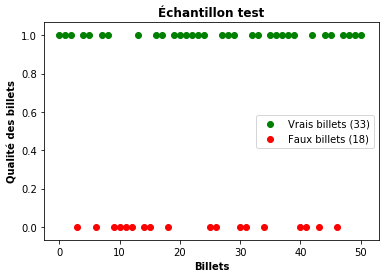

In [101]:
%matplotlib inline
n_vrais = len(df_etiquettes_faux_billets_test[df_etiquettes_faux_billets_test['boolean_test'].isin({1})])
n_faux = len(df_etiquettes_faux_billets_test[df_etiquettes_faux_billets_test['boolean_test'].isin({0})])
for i,ii in zip(df_etiquettes_faux_billets_test.index, df_etiquettes_faux_billets_test.boolean_test):
    if ii==1:
        vrais = plt.scatter(x=i,y=ii, c='g')
    elif ii==0:
        faux = plt.scatter(x=i, y=ii, c='r')
plt.xlabel('Billets', fontsize=10, fontweight='bold')
plt.ylabel('Qualité des billets', fontsize=10, fontweight='bold')
plt.legend((vrais, faux), ('Vrais billets ({})'.format(n_vrais), 'Faux billets ({})'.format(n_faux)))
plt.title('''Échantillon test''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/testing_sample.png', dpi=120)
plt.show()

### REGRESSION

In [102]:
classifier = LogisticRegression(random_state=0)

#training
classifier.fit(faux_billets_train, etiquettes_faux_billets_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [103]:
#prédiction test
pred_etiquettes_faux_billets = classifier.predict(faux_billets_test)
conf_matrix = confusion_matrix(etiquettes_faux_billets_test, pred_etiquettes_faux_billets)

In [104]:
#prediction results
pd.DataFrame(conf_matrix)

,0,1
0,18,0
1,0,33


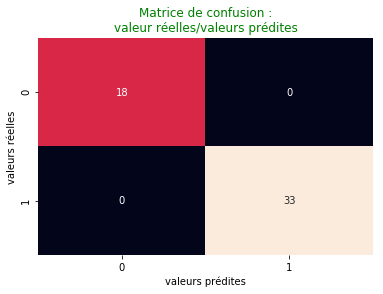

In [105]:
#nice confusion matrix
%matplotlib inline
sns.heatmap(conf_matrix, square=False, annot=True, cbar=False
            , xticklabels=['0','1']
            , yticklabels=['0','1'])
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');
plt.title('Matrice de confusion :\nvaleur réelles/valeurs prédites', color='g')
plt.savefig('./graphiques/confusion_matrix.png', dpi=120)
plt.show()

In [106]:
#prediction success rate
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(faux_billets_test, etiquettes_faux_billets_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [107]:
#algorithme quality
print(classification_report(etiquettes_faux_billets_test, pred_etiquettes_faux_billets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        33

   micro avg       1.00      1.00      1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



### Scores repartitton analysis (checking the strength of the separation between true and false bills)

In [108]:
score_predicts = classifier.decision_function(faux_billets_test)
df_score_test = pd.DataFrame(data=score_predicts, columns=['score'])
df_score_test['boolean'] = etiquettes_faux_billets_test

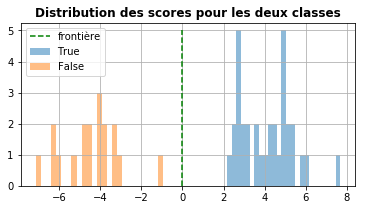

In [109]:
ax = df_score_test[df_score_test['boolean'] == True]['score'].hist(bins=25, figsize=(6,3), label='True', alpha=0.5)
df_score_test[df_score_test['boolean'] == False]['score'].hist(bins=25, ax=ax, label='False', alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes", fontsize=12, fontweight='bold')
ax.plot([0, 0], [0, 5],'g--', label="frontière")
ax.legend();

### Probabilities repartition analysis  (checking the strength of the predictions between true and false bills)

In [110]:
proba_predicts = classifier.predict_proba(faux_billets_test)[:,1]
df_proba_test = pd.DataFrame(data=proba_predicts, columns=['proba_being_true_1'])
df_proba_test['boolean'] = etiquettes_faux_billets_test

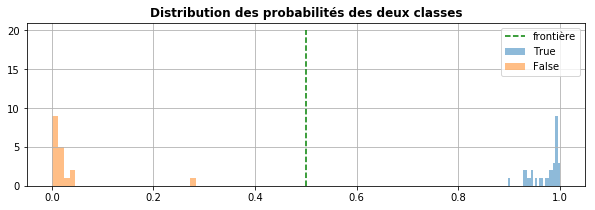

In [111]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,3))
df_proba_test[df_proba_test['boolean'] == True]['proba_being_true_1'].hist(bins=25, label='True', alpha=0.5)
df_proba_test[df_proba_test['boolean'] == False]['proba_being_true_1'].hist(bins=25, label='False', alpha=0.5)
plt.title('Distribution des probabilités des deux classes', fontsize=12, fontweight='bold')
plt.plot([0.5, 0.5], [0, 20], 'g--', label="frontière")
plt.legend()
plt.savefig('./graphiques/histo_proba_reg_logis.png', dpi=120)
plt.show()

### ROC CURVE (receiver operating characteristic): performance of the binary separation

In [112]:
proba_predicts_roc = classifier.predict_proba(faux_billets_test)
fpr0, tpr0, thresholds0 = roc_curve(etiquettes_faux_billets_test, proba_predicts_roc[:, 0], pos_label=classifier.classes_[0], drop_intermediate=False)

In [113]:
dftp = pd.DataFrame(dict(fpr=fpr0, tpr=tpr0, threshold=thresholds0)).copy()
dftp.head(n=2)

,fpr,tpr,threshold
0,0.0,0.000000,1.999196
1,0.0,0.055556,0.999196


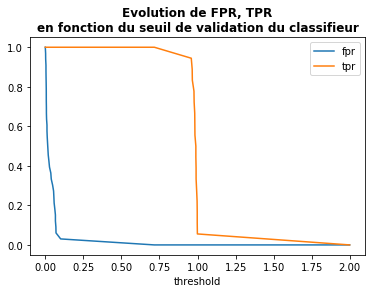

In [114]:
dftp.plot(x="threshold", y=['fpr', 'tpr'], figsize=(6, 4))
plt.title("Evolution de FPR, TPR\nen fonction du seuil de validation du classifieur", fontsize=12, fontweight='bold');

In [115]:
fpr0

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03030303,
        0.06060606,  0.09090909,  0.12121212,  0.15151515,  0.18181818,
        0.21212121,  0.24242424,  0.27272727,  0.3030303 ,  0.33333333,
        0.36363636,  0.39393939,  0.42424242,  0.45454545,  0.48484848,
        0.51515152,  0.54545455,  0.57575758,  0.60606061,  0.63636364,
        0.66666667,  0.6969697 ,  0.72727273,  0.75757576,  0.78787879,
        0.81818182,  0.84848485,  0.87878788,  0.90909091,  0.93939394,
        0.96969697,  1.        ])

In [116]:
tpr0

array([ 0.        ,  0.05555556,  0.11111111,  0.16666667,  0.22222222,
        0.27777778,  0.33333333,  0.38888889,  0.44444444,  0.5       ,
        0.55555556,  0.61111111,  0.66666667,  0.72222222,  0.77777778,
        0.83333333,  0.88888889,  0.94444444,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

#### <font color='red'>ROC CURVE<font>

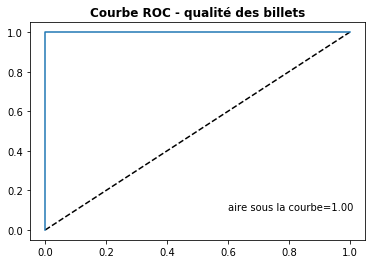

In [117]:
fig= plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0)
plt.title('Courbe ROC - qualité des billets', fontsize=12, fontweight='bold')
plt.annotate(s='aire sous la courbe={:1.2f}'.format(aucf),xy=(0.6,0.1))
plt.savefig('./graphiques/ROC_curve_reg_logis.png', dpi=120)
plt.show()

### Graph: results projection

In [118]:
df_pred_etiquettes_faux_billets = pd.DataFrame({'boolean_pred':pred_etiquettes_faux_billets})

In [119]:
df_etiquettes_faux_billets_test = pd.DataFrame({'boolean_test':etiquettes_faux_billets_test})

In [120]:
df_comparaison_predict_test = df_pred_etiquettes_faux_billets.merge(df_etiquettes_faux_billets_test, right_index=True,left_index=True)

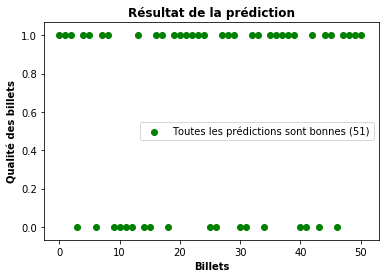

In [121]:
error=0
for i,predicting, testing in zip(df_comparaison_predict_test.index,df_comparaison_predict_test.boolean_pred,df_comparaison_predict_test.boolean_test):
    if predicting == testing:
        good_pred = plt.scatter(x=i, y = predicting, c='g')
    elif predicting!=testing:
        error==True
        wrong_pred = plt.scatter(x=i, y = predicting, c='r')
        expected_pred = plt.scatter(x=i, y = testing, c='b')
        error=error+1
    if error!=0:
        plt.legend((good_pred, wrong_pred, expected_pred), ('Bonnes prédictions ({})'.format(len(df_comparaison_predict_test)-error), 'Mauvaises prédictions ({})'.format(error), 'Prédictions espérées mais erronées'))
    elif error==0:
        plt.legend(['Toutes les prédictions sont bonnes ({})'.format(len(df_comparaison_predict_test))])

plt.xlabel('Billets', fontsize=10, fontweight='bold')
plt.ylabel('Qualité des billets', fontsize=10, fontweight='bold')
plt.title('''Résultat de la prédiction''', fontsize=12, fontweight='bold')
plt.savefig('./graphiques/result_test_predicting.png', dpi=120)
plt.show()

# <font color='blue'>LOGISTIC REGRESSION ALGORITHMUS<font>

In [122]:
def regression_logistic_and_predict(df_reference, boolean_column, file_to_predict, id_column_file):
#REGRESSION LOGISTIQUE
    #Standardisation des données
    df_reference_CR = df_reference.drop(columns=['{}'.format(boolean_column)])
    scaller =  preprocessing.StandardScaler().fit(df_reference_CR)
    df_reference_CR = scaller.transform(df_reference_CR)
    df_reference_CR = pd.DataFrame(df_reference_CR)
    
    #Séparation des caractéristiques des échantillons et leurs étiquette
    matrix_carac_ref = df_reference_CR.as_matrix()
    matrix_etiquettes_ref = df_reference['{}'.format(boolean_column)].as_matrix()
    etiquettes_ref = etiquettes_faux_billets.flatten() #retourne un array en 1 dimension [0],[0],[1] -> [0,0,1]
    
    #Séparation des données training et testing
    carac_train, carac_test, etiquettes_train, etiquettes_test = model_selection.train_test_split(matrix_carac_ref, matrix_etiquettes_ref,test_size=0.3)
    
    #préparation du module de régression logistique de sklearn
    classifier = LogisticRegression()
    #apprentissage
    classifier.fit(carac_train, etiquettes_train)
    
    #prédiction test
    etiquettes_pred = classifier.predict(carac_test)
    conf_matrix = confusion_matrix(etiquettes_test, etiquettes_pred)
    print('MATRICE DE CONFUSION:\n',pd.DataFrame(conf_matrix))
    
    #taux de résussite de la prédiction
    print('\nAccuracy of logistic regression classifier on test set: {:.2f}\n'.format(classifier.score(carac_test, etiquettes_test)))
    
    #qualité de l'algorithme
    print(classification_report(etiquettes_test, etiquettes_pred))
    
#APPLICATION SUR DES DONNEES A PREDIRE
    #DataFrame
    df_to_predict = pd.read_csv('./data/{}.csv'.format(file_to_predict))
    df_to_predict_carac = df_to_predict.drop(columns='{}'.format(id_column_file))
    df_to_predict_id = df_to_predict[['{}'.format(id_column_file)]]
    n_to_predict=len(df_to_predict)
    #standardisation
    scaller =  preprocessing.StandardScaler().fit(df_to_predict_carac)
    df_to_predict_carac_CR = scaller.transform(df_to_predict_carac)
    df_to_predict_carac_CR = pd.DataFrame(df_to_predict_carac_CR)
    
    #analyse
    résults_pred = classifier.predict(df_to_predict_carac_CR)
    print('Résultats:{}\n'.format(résults_pred))
   
    #DataFrame décisionnelle:
    data_id = df_to_predict['{}'.format(id_column_file)]
    data_proba_0 = classifier.predict_proba(df_to_predict_carac_CR)[0:n_to_predict, 0]
    data_proba_1 = classifier.predict_proba(df_to_predict_carac_CR)[0:n_to_predict, 1]
    data_decision={'id':data_id,'proba_being_0':data_proba_0,'proba_being_1':data_proba_1}
    df_decision = pd.DataFrame(data=data_decision)
    print (df_decision,'\n')
    
    for proba_true, i in zip(df_decision.proba_being_1, df_decision.id):
        if proba_true > 0.5:
            print('''Le billet identifié par : {} est VRAI avec une probabilité de : {}%\n'''.format(i, proba_true*100))
        elif proba_true < 0.5:
            print('''Le billet identifié par : {} est FAUX avec une probabilité de : {}%\n'''.format(i, 100-proba_true*100))
        else:
            print('Pobabilités égales que le pays soit vrai ou faux')

In [123]:
regression_logistic_and_predict(df_faux_billets_CR, 'is_genuine','exemple','id')

MATRICE DE CONFUSION:
     0   1
0  17   0
1   1  33

Accuracy of logistic regression classifier on test set: 0.98

              precision    recall  f1-score   support

       False       0.94      1.00      0.97        17
        True       1.00      0.97      0.99        34

   micro avg       0.98      0.98      0.98        51
   macro avg       0.97      0.99      0.98        51
weighted avg       0.98      0.98      0.98        51

Résultats:[False False False  True  True]

    id  proba_being_0  proba_being_1
0  B_1       0.909528       0.090472
1  B_2       0.977572       0.022428
2  B_3       0.973260       0.026740
3  B_4       0.003659       0.996341
4  B_5       0.000611       0.999389 

Le billet identifié par : B_1 est FAUX avec une probabilité de : 90.95283105261733%

Le billet identifié par : B_2 est FAUX avec une probabilité de : 97.75719628050197%

Le billet identifié par : B_3 est FAUX avec une probabilité de : 97.32604422967388%

Le billet identifié par : B_4 est V

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
